In [38]:
import polars as pl
from sklearn.ensemble import HistGradientBoostingClassifier
from datetime import datetime
import numpy as np
import geopandas as gpd
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.linear_model import RidgeClassifier
from cat_model_utils import run_model, get_cat_dict, classify_results, plot_ternary, plot_binary, reshape_data, get_features

### Load all data

In [3]:
##Load categorical land cover data, it is saved in a tricky format so we need to do some processing, converting list of [[band, value]...] to columns of band - proportion of area
band_names = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_scrub', 'built', 'bare', 'snow_ice']
land_use = (
    pl.read_csv('../data/land_use/dynamic_earth_all_munis_2017.csv')
    .with_columns(
        pl.col('histogram')
        .str.extract_all(
            r'\s[0-9]*\.[0-9]*'
        )
        .list.eval(pl.element().str.strip_chars())
        .cast(pl.List(pl.Float32))
    )
    .with_columns(
        pl.col('histogram').list.sum().alias('total_pixels'),
        pl.col('histogram').list.to_struct(fields=band_names)
    )
    .unnest('histogram')
    .with_columns(
        [pl.col(band)/(pl.col('total_pixels'))for band in band_names],
    )
    .select(pl.exclude('total_pixels'))
    .rename({'CD_MUN':'muni_id'})
)


In [4]:
#Load El nino data, cast and rename for join compatibility
el_nino = pl.read_csv('../data/sst/sst_indices.csv').rename({'YR': 'year', 'MON': 'month'}).with_columns(pl.col('year').cast(str), pl.col('month').cast(pl.UInt32))

In [5]:
#Load monthly dengue case counts -- Note, dengue download script has been updated, you can possibly just run this with a simple read_parquet
#monthly cases are aggregated from the start of the month forward, environmental parameters from the end of the month backwards
monthly_cases = (
    pl.read_parquet('../data/cases/agged/dengue_per_month.parquet')
                 .with_columns(pl.col('DT_NOTIFIC').dt.offset_by('1mo').alias('end_date'))
                 .with_columns(pl.col('ID_MUNICIP').str.slice(offset=0,length=6).cast(pl.Int64))
                 .sort('DT_NOTIFIC')
                 .rename({
                    'DT_NOTIFIC': 'start_date',
                    'ID_MUNICIP': 'muni_id'
                    })
)

#We also want to fill out all municipios for which we have no cases pre the training cutoff 2018-01-01

no_cases = (
    monthly_cases
    .filter(pl.col('start_date')<datetime(2018,1,1))
    .with_columns(pl.col('count').sum().over('muni_id').alias('count_sum'))
    .filter(pl.col('count_sum')!=0)
    .select(pl.col('muni_id')).unique().to_series()
)

monthly_cases = monthly_cases.filter(pl.col('muni_id').is_in(no_cases))


In [6]:
#Load google earth engine dynamic exports
monthly_params = pl.read_parquet('../data/gee_exports_test/all_parameters_2001-01-01_2021-01-01_months.parquet')

In [7]:
#load municipio polygons, used in plotting later
munis = gpd.read_file('../data/brazil/munis/munis_simple.shp').astype({'CD_MUN': 'string'})
munis['CD_MUN'] = munis['CD_MUN'].str.slice(stop=-1).astype(int)

In [8]:
#join datasets
all_data = (
    monthly_cases.join(monthly_params, how='inner', on=['muni_id', 'end_date']).with_columns(pl.col('end_date').alias('month').dt.month())
    .join(el_nino, how='left', on=['year', 'month'])
    .join(land_use, how='left', on='muni_id')
)

## Tests
Note: we have random_state set for all models. Disable or change this for different results

In [27]:
#Dictionary to hold base results from two model types
MODEL_RESULTS = {}

#Dictionary to hold case lookback results
LOOKBACK_RESULTS = {}

#Dictionary to hold environmental feature results
ENV_RESULTS = {}

#We are going to be exploring case lags 1-4
LAGS = [1,2,3,4]

#We are also exploring the different cat_fns
CAT_DICT = get_cat_dict()

#Common vars for experiments
TRAIN_START = '2005-01-01'
TRAIN_END = '2018-01-01'
TEST_END = '2020-01-01'

##### 1. Ridge Regression Classification using Binary/Ternary and Simple/Relative - Most basic classification model (linear least squares regression)

In [32]:
#Running results for binary/ternary and simple relatives over case lags 1-4
MODEL_RESULTS['ridge_regression'] = {cat_style: dict() for cat_style in CAT_DICT.keys()}
for cat_style, cat_fn in CAT_DICT.items():
    for lag in LAGS:
        clf = RidgeClassifier(random_state=42)
        results = run_model(
            all_data,
            TRAIN_START,
            TRAIN_END,
            TEST_END,
            clf,
            cat_fn=cat_fn,
            cat_style=cat_style, 
            case_lag=lag
        )
        MODEL_RESULTS['ridge_regression'][cat_style][lag] = results

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    118016
         1.0       0.05      0.00      0.00      6662
         2.0       0.00      0.00      0.00      4946

    accuracy                           0.91    129624
   macro avg       0.32      0.33      0.32    129624
weighted avg       0.83      0.91      0.87    129624



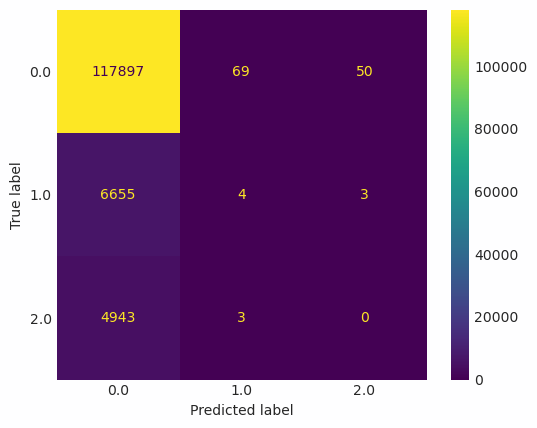

In [33]:
#Results
for cat_style, lag_results in MODEL_RESULTS['ridge_regression'].items():
    for lag, results in lag_results.items():
        print(cat_style)
        print(f'case lag {lag}')
        classify_results(results)

In [34]:
#See How MODEL_RESULTS is organized
MODEL_RESULTS['ridge_regression']
#MODEL_RESULTS[experiment_label][cat_style][case_lag]

# Note: because of inconsistencies between list columns in 
# different experiments we do not combine them all into one 
# dataframe, that can be done later

{'relative_ternary': {1: {'results': shape: (129_624, 12)
   ┌────────────┬────────────┬────────────┬─────────┬───┬──────────┬─────────┬────────────┬───────────┐
   │ prediction ┆ ground_tru ┆ date       ┆ muni_id ┆ … ┆ case_lag ┆ env_lag ┆ specific_c ┆ specific_ │
   │ s          ┆ th         ┆ ---        ┆ ---     ┆   ┆ ---      ┆ ---     ┆ ases       ┆ env       │
   │ ---        ┆ ---        ┆ date       ┆ i64     ┆   ┆ i64      ┆ i64     ┆ ---        ┆ ---       │
   │ f64        ┆ f64        ┆            ┆         ┆   ┆          ┆         ┆ list[null] ┆ list[null │
   │            ┆            ┆            ┆         ┆   ┆          ┆         ┆            ┆ ]         │
   ╞════════════╪════════════╪════════════╪═════════╪═══╪══════════╪═════════╪════════════╪═══════════╡
   │ 0.0        ┆ 0.0        ┆ 2018-01-01 ┆ 110001  ┆ … ┆ 1        ┆ 0       ┆ [null]     ┆ [null]    │
   │ 0.0        ┆ 0.0        ┆ 2018-01-01 ┆ 110002  ┆ … ┆ 1        ┆ 0       ┆ [null]     ┆ [null]    │
   │ 0

##### 2. Classification using Gradient Boosting Classifier

In [35]:
#Running results for binary/ternary and simple relatives over case lags 1-4
MODEL_RESULTS['gradient_boosting'] = {cat_style: dict() for cat_style in CAT_DICT.keys()}
for cat_style, cat_fn in CAT_DICT.items():
    for lag in LAGS:
        clf = HistGradientBoostingClassifier(categorical_features=['month'], random_state=42, max_iter=1000)
        results = run_model(
            all_data,
            TRAIN_START,
            TRAIN_END,
            TEST_END,
            clf,
            cat_fn=cat_fn,
            cat_style=cat_style,
            case_lag=lag
        )
        MODEL_RESULTS['gradient_boosting'][cat_style][lag] = results

In [ ]:
#Results
for cat_style, lag_results in MODEL_RESULTS['gradient_boosting'].items():
    for lag, results in lag_results.items():
        print(cat_style)
        print(f'case lag {lag}')
        classify_results(results)

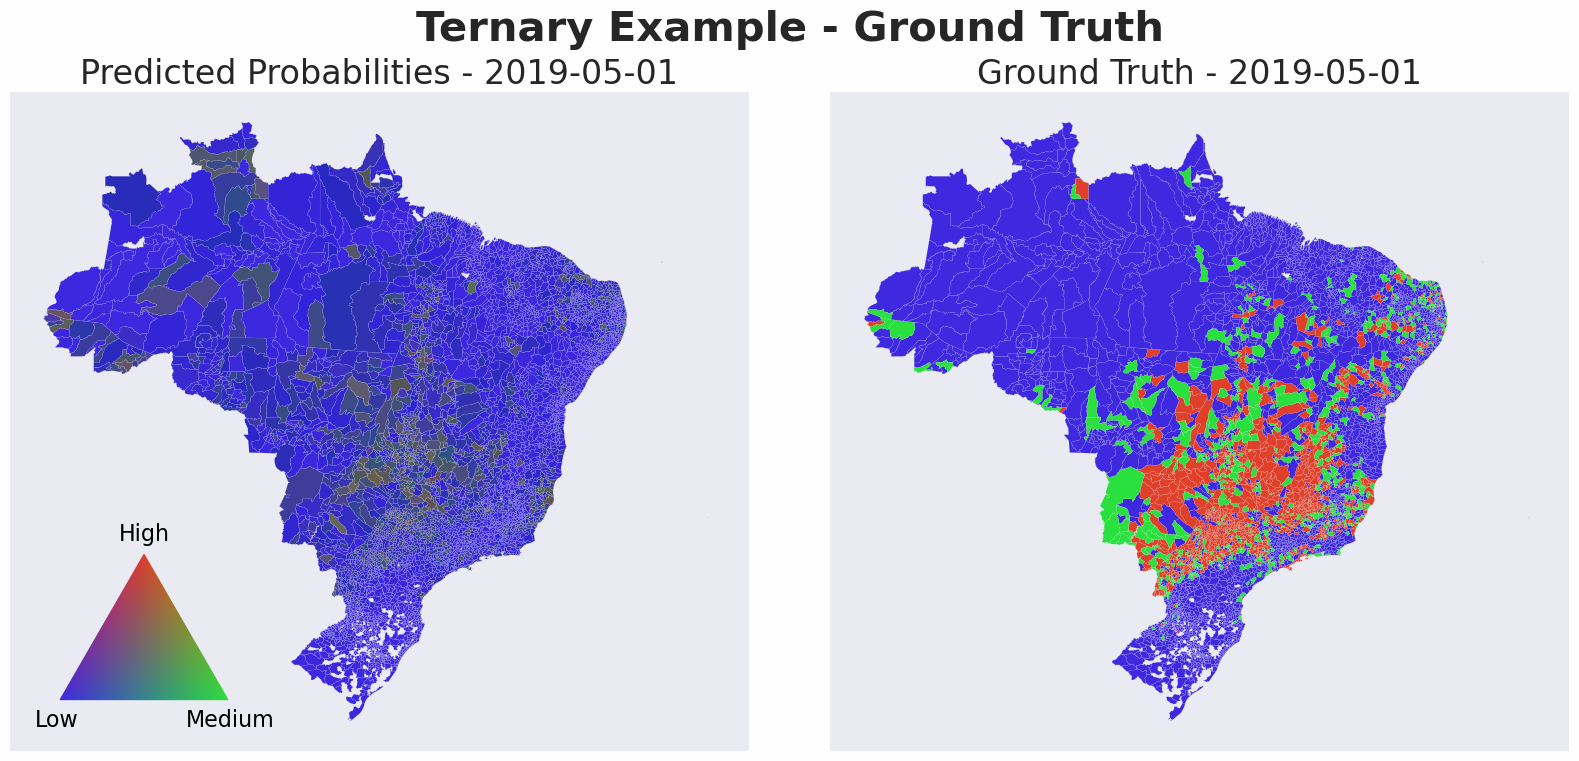

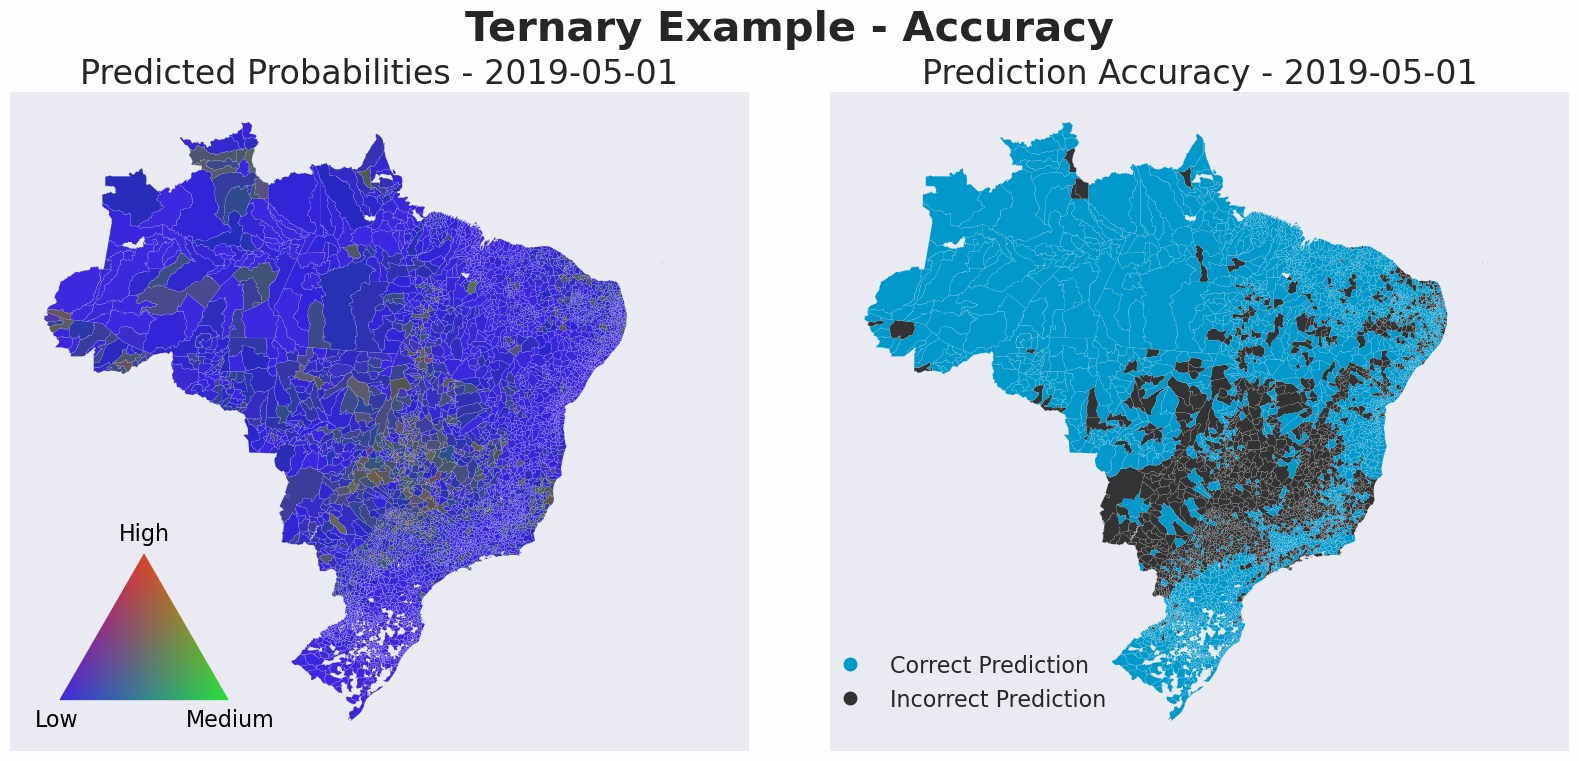

In [36]:
# Since gradient boosting classifier outputs probabilities, we can use them to create probability maps
# Binary classification can be plotted with with plot_binary function

# probabilities + ground truth
fig, ax = plot_ternary(results['results'], munis, '2019-05-01', 'Ternary Example - Ground Truth', accuracy=False)

# probabilities + accuracy
fig, ax = plot_ternary(results['results'], munis, '2019-05-01', 'Ternary Example - Accuracy', accuracy=True)

##### 3. Case Lookback Search - How many prior months of cases to include

In [37]:
#Just going to use Gradient boosting and case lag = 1 for this. 
# Add another nested loop to perform case lag search as well
#LOOKBACK_RESULTS[cat_style][case_lookback]

#Running results for binary/ternary and simple relatives over lookbacks 1-48
LOOKBACK_RESULTS = {cat_style: dict() for cat_style in CAT_DICT.keys()}
LOOKBACKS = range(1, 49)
for cat_style, cat_fn in CAT_DICT.items():
    for lookback in LOOKBACKS:
        clf = HistGradientBoostingClassifier(categorical_features=['month'], random_state=42, max_iter=1000)
        results = run_model(
            all_data,
            TRAIN_START,
            TRAIN_END,
            TEST_END,
            clf,
            cat_fn=cat_fn,
            cat_style=cat_style,
            case_lag=1,
            case_lookback=lookback
        )
        LOOKBACK_RESULTS[cat_style][lookback] = results

In [ ]:
#Results
for cat_style, lookback_results in LOOKBACK_RESULTS.items():
    for lookback, results in lookback_results.items():
        print(cat_style)
        print(f'case lookback {lookback}')
        classify_results(results)

##### 4. Non-contiguous time-lag search

In [54]:
#Too many combinations to try so we are going to use the sklearn Sequential Feature Selector and TimeSeries
#There are some real limitations to Sequential Feature Selector, there are definitely more rigorous ways to implement this
#This can also take 5+ hours to run
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit


NC_LOOKBACK = dict()

time_data = reshape_data(TRAIN_START, TEST_END, all_data, case_lookback=48, env_list=[])
for cat_style, cat_fn in CAT_DICT.items():
    time_features = get_features(time_data, cat_vars=['month'], cat_fn=cat_fn)
    reg = HistGradientBoostingClassifier(random_state=42, max_iter=1000)

    sfs = SequentialFeatureSelector(reg, n_features_to_select='auto', tol=0.001, scoring='f1_macro', cv=TimeSeriesSplit(n_splits=4), n_jobs=-1)
    sfs.fit(time_features['X'], time_features['y'])
    NC_LOOKBACK[cat_style]=sfs

for k, v in NC_LOOKBACK.items():
    print(k)
    print(v.get_feature_names_out())



##### 5. Environmental feature search

In [ ]:
#ENV_RESULTS[feature][case_lag]
#just doing relative binary for simplicity, add a nested loop to test other cat_fns
env_feats = [
#SDM features
 ['temporal_sdm_both'],
 ['temporal_sdm_albopictus'],
 ['temporal_sdm_aegypti'],
 #Remote sensing
 ['EVI'],
 ['total_evaporation_sum'],
 ['total_precipitation_sum'],
 ['evaporation_from_open_water_surfaces_excluding_oceans_min'],
 ['soil_temperature_level_1'],
 ['runoff_sum'],
 ['surface_runoff_min'],
 ['volumetric_soil_water_layer_1'],
 ['dewpoint_temperature_2m'],
 ['temperature_2m'],
 ['total_precipitation_min'],
 #land use
 ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_scrub', 'built', 'bare', 'snow_ice'],
 ['water'],
 ['trees'],
 ['grass'],
 ['flooded_vegetation'],
 ['crops'],
 ['shrub_scrub'],
 ['built'],
 ['bare'],
 ['snow_ice'],
 #El nino
 ['NINO1+2'],
 ['ANOM'],
 ['NINO3'],
 ['ANOM_1'],
 ['NINO4'],
 ['ANOM_2'],	
 ['NINO3.]4',	
 ['ANOM_3'],
]

ENV_RESULTS = {str(env_feat):dict() for env_feat in env_feats}

for env_feat in env_feats:
    for lag in LAGS:
        clf = HistGradientBoostingClassifier(categorical_features=['month'], random_state=42, max_iter=1000)
        results = run_model(
            all_data,
            TRAIN_START,
            TRAIN_END,
            TEST_END,
            clf,
            cat_fn=CAT_DICT['relative_binary'],
            cat_style='relative_binary',
            case_lag=lag,
            case_lookback=24,
            env_lookback=12,
            env_list=env_feat
        )
        ENV_RESULTS[str(env_feat)][lag] = results


In [ ]:
#Results
for env_feat, lag_results in ENV_RESULTS.items():
    for lag, results in lookback_results.items():
        print(env_feat)
        print(f'case lag {lag}')
        classify_results(results)

##### 6. Hyperparameter search

In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
import scipy.stats as stats

tune_data = reshape_data(TRAIN_START, TEST_END, all_data, case_lookback=48, env_list=[])
tune_features = get_features(tune_data, CAT_DICT['relative_binary'])
param_grid = {
    'histgradientboostingclassifier__learning_rate': stats.loguniform(.0001, .1 ),
    'histgradientboostingclassifier__l2_regularization': stats.uniform(0,2),
    'histgradientboostingclassifier__max_leaf_nodes': stats.randint(1, 100),
    'histgradientboostingclassifier__min_samples_leaf': stats.randint(20, 250)
}

clf = HistGradientBoostingClassifier(
    random_state=42,
    early_stopping=True,
    class_weight='balanced',
    categorical_features=['month'],
    )


gsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=param_grid, factor=2, random_state=42, cv=TimeSeriesSplit(n_splits=4), scoring='balanced_accuracy', verbose=1,
    min_resources=100, max_resources=5000, resource='histgradientboostingclassifier__max_iter',
)

search = gsh.fit(tune_features['X'], tune_features['y'])
#grid_pipeline.named_steps
search.best_params_


##### 7. Lag-correlated municipios

In [ ]:
#Includes data from n-1 most highly correlated municipio as a feature (data from the previous month from the closest neighbor in terms of lagged case rate over time)

from datetime import date
corr_data = (all_data
             .select(['muni_id', 'start_date', 'cases_per_100k'])
             .sort('start_date')
             .filter(pl.col('start_date')<date(2018,1,1))
             .with_columns(pl.col('cases_per_100k').sum().over('muni_id').alias('muni_sum'))
             .filter(pl.col('muni_sum')!=0)
             .select(pl.exclude('muni_sum')).sort('start_date')
)
shifted_data = corr_data.with_columns(pl.col('cases_per_100k').shift(1).over('muni_id').alias('shifted_cases')).drop_nulls()

shifted_data_full = (all_data
              .sort('start_date')
             .select(['muni_id', 'start_date', 'cases_per_100k'])
             .with_columns(pl.col('cases_per_100k').shift(1).over('muni_id').alias('shifted_cases')).drop_nulls()
)

muni_ids = shifted_data.select(pl.col('muni_id')).unique().sort('muni_id').to_series()

muni_mapper = {i:str(d) for i, d in enumerate(muni_ids)}

#get data for time n
wide_shifted = (shifted_data
                .select(pl.exclude('cases_per_100k'))
                .pivot(values='shifted_cases', 
                       index='start_date', 
                       columns='muni_id', 
                       aggregate_function=None,
                       sort_columns=True)
                .select(pl.exclude('start_date')))
#get data from time n-1
wide_orig = (shifted_data
             .select(pl.exclude('shifted_cases'))
             .pivot(values='cases_per_100k', 
                    index='start_date', 
                    columns='muni_id', 
                    aggregate_function=None,
                    sort_columns=True)
            .select(pl.exclude('start_date')))
 
#get per-municipio correlations between time n-1 and time n
shifted_corrs = np.corrcoef(wide_shifted, wide_orig, rowvar=False)

#Upper right = correlations between shifted and original
selected_corrs = shifted_corrs[len(muni_ids):, :len(muni_ids)]




In [ ]:
#Validating
from scipy.stats import pearsonr 
print(np.nanargmax(selected_corrs[4,:]))

print(selected_corrs[4,2450])
pearsonr(
    wide_shifted.select(
        pl.col(
            muni_mapper[np.nanargmax(selected_corrs[4,:])]
            )).to_series(), 
    wide_orig.select(
        pl.col(muni_mapper[4])
        ).to_series()
    )

In [ ]:
#Get muni_id and top correlated shifted muni_id
muni_ids = [int(muni_mapper[ix]) for ix in range(0, len(selected_corrs))]
#print(muni_ids)

#Need to eliminate self
#print(shifted_id)
shifted_id = []
for i in range(0, len(selected_corrs)):
    mask = ~np.isin(np.arange(len(selected_corrs)), i)
    subset_idx = np.nanargmax(selected_corrs[i, :][mask])
    parent_idx = np.arange(len(selected_corrs))[mask][subset_idx]
    shifted_id.append(int(muni_mapper[parent_idx]))
#print(shifted_id)

#Now we can use this to join our original datafrae with a time shifted dataframe
corr_df = pl.DataFrame({'muni_id':muni_ids, 'top_correlated_id': shifted_id})
    

In [ ]:
data_with_corrs = (all_data
                   .join(corr_df, on='muni_id', how='inner')
                   .join(shifted_data_full.select(pl.exclude('cases_per_100k')), 
                         left_on=['top_correlated_id', 'start_date'], 
                         right_on=['muni_id', 'start_date'], 
                         how='inner'))


In [ ]:
NEIGHBOR_RESULTS = {cat_style: dict() for cat_style in CAT_DICT.keys()}
for cat_style, cat_fn in CAT_DICT.items():
    for lag in LAGS:
        clf = HistGradientBoostingClassifier(categorical_features=['month'], random_state=42, max_iter=1000)
        results = run_model(
            all_data,
            TRAIN_START,
            TRAIN_END,
            TEST_END,
            clf,
            cat_fn=cat_fn,
            cat_style=cat_style,
            case_lag=lag,
            env_list=['shifted_cases'],
            env_lookback=24
        )
        NEIGHBOR_RESULTS[cat_style][lag] = results

In [ ]:
#Results
for cat_style, lag_results in NEIGHBOR_RESULTS.items():
    for lag, results in lag_results.items():
        print(cat_style)
        print(f'case lag {lag}')
        classify_results(results)